In [1]:
import os
import torch
import random
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from matplotlib import cm
from torch.amp import autocast, GradScaler
from scipy.linalg import expm
from qutip import Bloch, Qobj

GPU Management

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
!set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:2'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [5]:
print("__Python VERSION:", sys.version)
print("__pyTorch VERSION:", torch.__version__)

__Python VERSION: 3.12.3 (main, Sep  4 2024, 12:08:24) [GCC 13.2.0]
__pyTorch VERSION: 2.4.1+cu124


In [6]:
print("__CUDA VERSION")
!nvidia-smi

__CUDA VERSION
Wed Sep  4 22:41:37 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   64C    P5              8W /   50W |      96MiB /   4096MiB |     22%      Default |
|                                         |                        |                  N/A |
+--------------------------------

In [7]:
print("__CUDNN VERSION:", torch.backends.cudnn.version())
!nvcc --version

__CUDNN VERSION: 90100
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Aug_14_10:10:22_PDT_2024
Cuda compilation tools, release 12.6, V12.6.68
Build cuda_12.6.r12.6/compiler.34714021_0


In [8]:
print("__Number CUDA Devices:", torch.cuda.device_count())
print("__Devices")
print("Available devices ", torch.cuda.device_count())
print("Active CUDA Device: GPU", torch.cuda.current_device())

__Number CUDA Devices: 1
__Devices
Available devices  1
Active CUDA Device: GPU 0


In [9]:
# Hyperparameters
LEARNING_RATE = 1e-4
GAMMA = 0.9
BATCH_SIZE = 512
TARGET_UPDATE = 10
EPISODES = 200000
PATIENCE = EPISODES / 2
MAX_STEPS = 10
FIDELITY_THRESHOLD = 1e-5

# Define Pauli matrices
I = np.eye(2)
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
# Define Hamiltonian parameters
omega = 1.0
J = 0.1

# Define Gates
HADAMARD = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
T_GATE = np.array([[1, 0], [0, np.exp(1j * np.pi / 4)]], dtype=np.complex128)
CNOT = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])

In [10]:
class QuantumGateEnv:
    """
    A class to represent the environment for quantum gate control using reinforcement learning.

    Attributes:
    ----------
    gate : str
        The type of quantum gate (e.g., 'H', 'T', 'CNOT').
    control_pulse_params : dict
        Dictionary containing amplitude, phase, and duration parameters for control pulses.
    initial_state : np.ndarray
        The initial quantum state of the system.
    state : np.ndarray
        The current quantum state of the system.
    target : np.ndarray
        The target quantum gate matrix.
    theoretical_state : np.ndarray
        The expected quantum state after applying the target gate.
    time_step : int
        The current time step in the episode.
    max_steps : int
        The maximum number of steps in an episode.
    state_history : list
        A history of quantum states during an episode.
    """

    def __init__(self, gate):
        """
        Initializes the QuantumGateEnv with the specified gate type.

        Parameters:
        ----------
        gate : str
            The type of quantum gate (e.g., 'H', 'T', 'CNOT').
        """
        self.control_pulse_params = {
            "amplitude": np.linspace(0, 1, 12),  # Example amplitudes
            "phase": np.linspace(-np.pi, np.pi, 12),  # Example phases
            "duration": np.linspace(0.1, 1.0, 120),  # Example durations
        }
        self.gate = gate
        (
            self.initial_state,
            self.target_state,
            self.state_size,
            self.action_size,
            self.input_features,
            self.hidden_features
        ) = self.set_quantum_info()
        self.reset()

    def set_quantum_info(self):
        """
        Sets the quantum information for the environment based on the gate type.

        Returns:
        -------
        tuple
            A tuple containing the initial state, target_state, state size, action size, and input features.
        """
        action_size = (
            len(self.control_pulse_params["amplitude"])
            * len(self.control_pulse_params["phase"])
            * len(self.control_pulse_params["duration"])
        )

        if self.gate in ["H", "T"]:
            num_qubits = 1
            state_size = 2**num_qubits
            initial_states = [
                np.array([1, 0], dtype=np.complex128),
                np.array([0, 1], dtype=np.complex128),
            ]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            unitary = HADAMARD if self.gate == "H" else T_GATE
            target_state = np.dot(initial_state, unitary)

        elif self.gate == "CNOT":
            num_qubits = 2
            state_size = 2**num_qubits
            initial_states = [
                np.array([1, 0, 0, 0], dtype=np.complex128),
                np.array([0, 1, 0, 0], dtype=np.complex128),
                np.array([0, 0, 1, 0], dtype=np.complex128),
                np.array([0, 0, 0, 1], dtype=np.complex128),
            ]
            initial_state = random.choice(initial_states)
            input_features = 2 ** (
                num_qubits + 1
            )  # Number of states in the input space
            hidden_features = 512
            unitary = CNOT
            target_state = np.dot(initial_state, unitary)

        return (
            initial_state,
            target_state,
            state_size,
            action_size,
            input_features,
            hidden_features,
        )

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
        -------
        np.ndarray
            The initial quantum state.
        """
        self.state = self.initial_state.copy()
        self.time_step = 0
        self.max_steps = MAX_STEPS
        self.reward_episode = [-1]
        self.fidelity_episode = [0]
        self.state_episode = [self.state]
        self.amplitude_episode = [0]
        self.phase_episode = [0]
        self.duration_episode = [0]
        return self.state

    def _time_evolution_operator(self, H, t):
        """
        Compute the time evolution operator U(t) = exp(-i * H * t).

        Parameters:
        H (ndarray): The Hamiltonian matrix.
        t (float): The time over which to evolve the system.

        Returns:
        ndarray: The time evolution operator U(t).
        """
        return expm(-1j * H * t)

    def _construct_hamiltonian(self, amplitude, phase):
        """
        Constructs the Hamiltonian for the quantum gate operation based on the gate type.

        Parameters:
        ----------
        amplitude : float
            The amplitude of the control Hamiltonian, which modulates the strength of the control fields.
        phase : float
            The phase of the control Hamiltonian, which determines the direction of the control field in the XY-plane.

        Returns:
        -------
        H_total : ndarray
            The total Hamiltonian (system + control) for the specified gate operation.
            If the gate is "H" or "T", returns a 2x2 matrix.
            If the gate is "CNOT", returns a 4x4 matrix.
        """
        if self.gate in ["H", "T"]:
            H_sys = (omega / 2) * Z  # System Hamiltonian (static)
            H_control = amplitude * (
                np.cos(phase) * X + np.sin(phase) * Y
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_sys + H_control  # Total Hamiltonian
        elif self.gate == "CNOT":
            H_system = (
                (omega / 2) * np.kron(Z, I)
                + (omega / 2) * np.kron(I, Z)
                + J * (np.kron(X, X) + np.kron(Y, Y))
            )  # System Hamiltonian (static)
            H_control = amplitude * (
                np.kron(X, I) * np.cos(phase) + np.kron(Y, I) * np.sin(phase)
            )  # Control Hamiltonian (depends on amplitude and phase)
            return H_system + H_control  # Total Hamiltonian

    def infidelity(self, final_state):
        """
        Calculates the infidelity between the final state and the theoretical state.

        Parameters:
        ----------
        final_state (np.ndarray): The final quantum state after applying the control pulse.

        Returns:
        -------
        float
            The infidelity between the final state and the theoretical state.
        """
        fidelity = np.abs(np.dot(np.conjugate(self.target_state), final_state)) ** 2
        return 1 - fidelity

    def step(self, action):
        self.time_step += 1

        num_phases = len(self.control_pulse_params["phase"])
        num_durations = len(self.control_pulse_params["duration"])

        amplitude_index = action // (num_phases * num_durations)
        phase_index = (action // num_durations) % num_phases
        duration_index = action % num_durations

        amplitude = self.control_pulse_params["amplitude"][amplitude_index]
        phase = self.control_pulse_params["phase"][phase_index]
        duration = self.control_pulse_params["duration"][duration_index]

        control_hamiltonian = self._construct_hamiltonian(amplitude, phase)
        control_matrix = self._time_evolution_operator(control_hamiltonian, duration)

        next_state = np.dot(control_matrix, self.state)
        self.state = next_state

        # Store episode
        self.state_episode.append(self.state)
        self.amplitude_episode.append(amplitude)
        self.phase_episode.append(phase)
        self.duration_episode.append(duration)

        reward = -self.infidelity(next_state) if self.time_step == self.max_steps else 0
        fidelity = 1 + reward
        self.reward_episode.append(reward)
        self.fidelity_episode.append(fidelity)
        done = self.time_step == self.max_steps

        return (
            done,
            next_state,
            amplitude,
            phase,
            duration,
            reward,
            fidelity,
        )

In [11]:
# REINFORCE Policy Network
class PolicyNetwork(nn.Module):

    def __init__(self, state_size, action_size, dropout=0.1):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(env.input_features, env.hidden_features)
        self.fc2 = nn.Linear(env.hidden_features, env.action_size)
        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def forward(self, state):
        x = self.dropout(torch.relu(self.fc1(state)))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)
    
    def _initialize_weights(self):
        def init_weights(layer):
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias)
        self.apply(init_weights)

In [12]:
# REINFORCE Agent
class REINFORCEAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.policy = PolicyNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(
            self.policy.parameters(),
            lr=LEARNING_RATE,
            amsgrad=True,
            weight_decay=LEARNING_RATE * 0.1,
        )
        self.scaler = GradScaler(device=device.type)

    def select_action(self, state):
        state = torch.FloatTensor(
            np.array(np.concatenate([state.real, state.imag]))
        ).to(device)
        with autocast(device_type=device.type):
            probs = self.policy(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
        return action.item(), dist.log_prob(action)

    def update_policy(self, rewards, log_probs):
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + GAMMA * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)

        # Normalize rewards
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (
            discounted_rewards.std() + 1e-10
        )

        policy_loss = [
            -log_prob * reward
            for log_prob, reward in zip(log_probs, discounted_rewards)
        ]
        policy_loss = torch.sum(torch.stack(policy_loss))

        self.optimizer.zero_grad(set_to_none=True)
        self.scaler.scale(policy_loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()

In [13]:
# Training the agent
def train_agent(agent, env, episodes, target_update, fidelity_threshold, patience):

    reward_history = []
    fidelity_history = []
    state_history = []
    amplitude_history = []
    phase_history = []
    duration_history = []
    best_fidelity = 0
    patience_counter = 0

    for e in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        total_reward = 0
        for _ in range(env.max_steps):
            action, log_prob = agent.select_action(state)
            (done, next_state, amplitude, phase, duration, reward, fidelity) = env.step(
                action
            )
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            total_reward += reward
            if done:
                break

        if e % target_update == 0:
            agent.update_policy(rewards, log_probs)

        state_history.append(state)
        amplitude_history.append(amplitude)
        phase_history.append(phase)
        duration_history.append(duration)
        reward_history.append(total_reward)
        fidelity_history.append(fidelity)

        if e % (EPISODES / 100) == 0:
            print(
                f"Episode: {e}/{episodes},  Reward: {total_reward:.5f}, "
                f"Fidelity: {fidelity_history[-1]:.5f}"
            )

        current_fidelity = 1 - env.infidelity(state)
        # Early stopping check
        if current_fidelity >= best_fidelity:
            best_fidelity = current_fidelity
            patience_counter = 0  # Reset patience counter if fidelity improves
        else:
            patience_counter += 1

        if best_fidelity >= (1 - fidelity_threshold) or patience_counter >= patience:
            print(
                f"Early stopping triggered. Achieved fidelity: {best_fidelity:.5f}, "
                f"Episode: {e}, Patience: {patience_counter}, Reward: {total_reward:.5f}"
            )
            break

    print("Training finished.")
    return (
        reward_history,
        fidelity_history,
        state_history,
        amplitude_history,
        phase_history,
        duration_history,
    )

In [14]:
def plot_results(
    rewards, fidelities, amplitudes, phases, durations, last_episode=False
):
    """
    Plots the results of the training process, including rewards,
    fidelities, and control pulse parameters.

    Parameters:
    ----------
    rewards : list
        A list of rewards per episode.
    fidelities : list
        A list of fidelities per episode.
    amplitudes : list
        A list of amplitudes of control pulses per episode.
    phases : list
        A list of phases of control pulses per episode.
    durations : list
        A list of durations of control pulses per episode.
    last_episode : bool, optional
        If True, indicates that the data is from the last episode only.
        In this case, the x-axis will not be logarithmic.
    """
    data = [
        (rewards, "Reward per Episode", "Reward"),
        (fidelities, "Fidelity per Episode", "Fidelity"),
        (amplitudes, "Amplitude per Episode", "Amplitude", "r"),
        (phases, "Phase per Episode", "Phase", "g"),
        (durations, "Duration per Episode", "Duration", "b"),
    ]

    plt.figure(figsize=(15, 20))

    for i, (data_series, label, ylabel, *color) in enumerate(data):
        plt.subplot(5, 1, i + 1)
        plt.plot(data_series, label=label, color=color[0] if color else None)

        # Apply log scale if not last episode and data is long enough
        if not last_episode:
            plt.xscale("log")

        plt.xlabel("Episode" if not last_episode else "Step")
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [15]:
def plot_bloch_sphere_trajectory(states):
    bloch = Bloch()
    # Add states
    for state in states:
        bloch.add_states(Qobj(state))
    bloch.show()
    plt.show()

H-Gate

In [16]:
# Initialize environment and agent
env = QuantumGateEnv(gate="H")
agent = REINFORCEAgent(env.state_size, env.action_size)

In [17]:
# Compile the model (requires PyTorch 2.0 or later)
if torch.__version__ >= "2.0.0":
    agent.policy = torch.compile(agent.policy)

In [18]:
# Train the agent
(   
    reward_history,
    fidelity_history,
    state_history,
    amplitude_history,
    phase_history,
    duration_history,
) = train_agent(agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.67614, Fidelity: 0.32386
Episode: 2000/200000,  Reward: -0.00000, Fidelity: 1.00000
Early stopping triggered. Achieved fidelity: 1.00000, Episode: 2000, Patience: 0, Reward: -0.00000
Training finished.


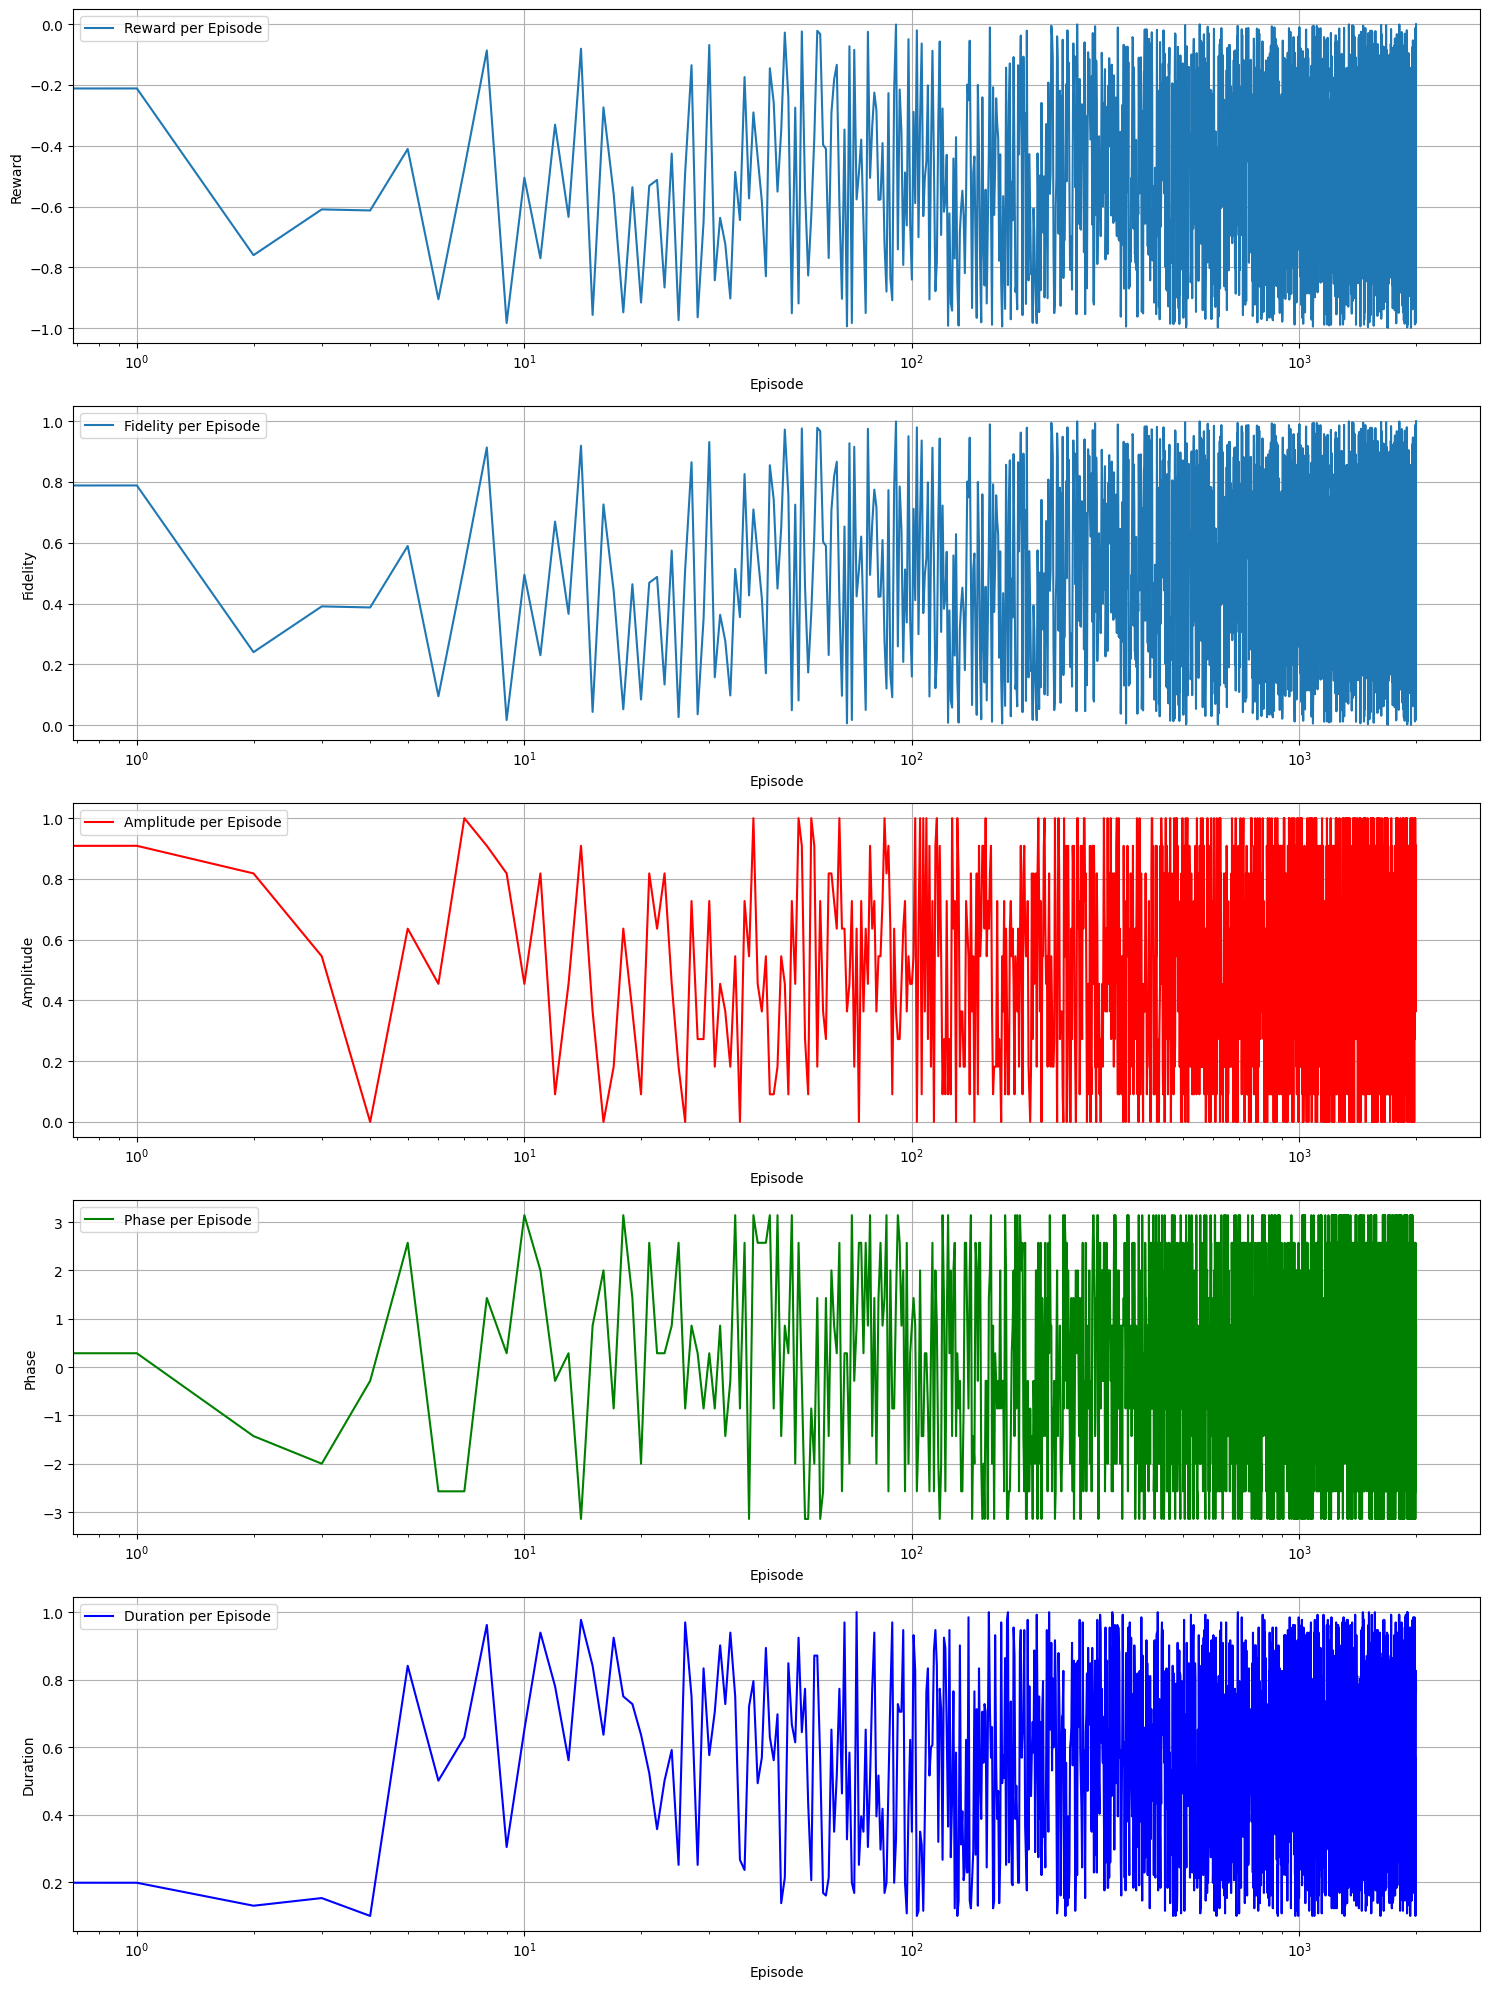

In [19]:
# Plot Results
plot_results(
    reward_history,
    fidelity_history,
    amplitude_history,
    phase_history,
    duration_history,
    False,
)

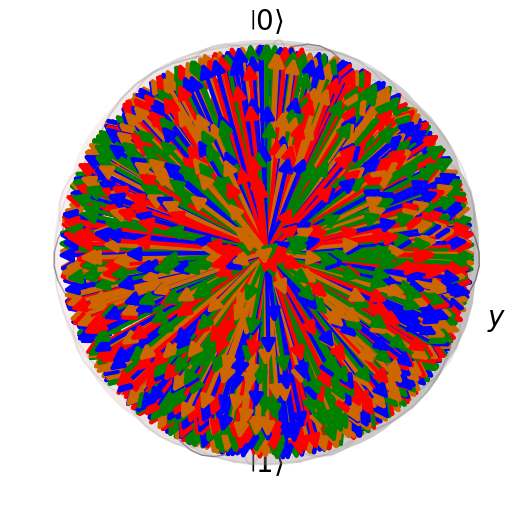

In [20]:
# Plot Bloch Sphere
plot_bloch_sphere_trajectory(state_history)

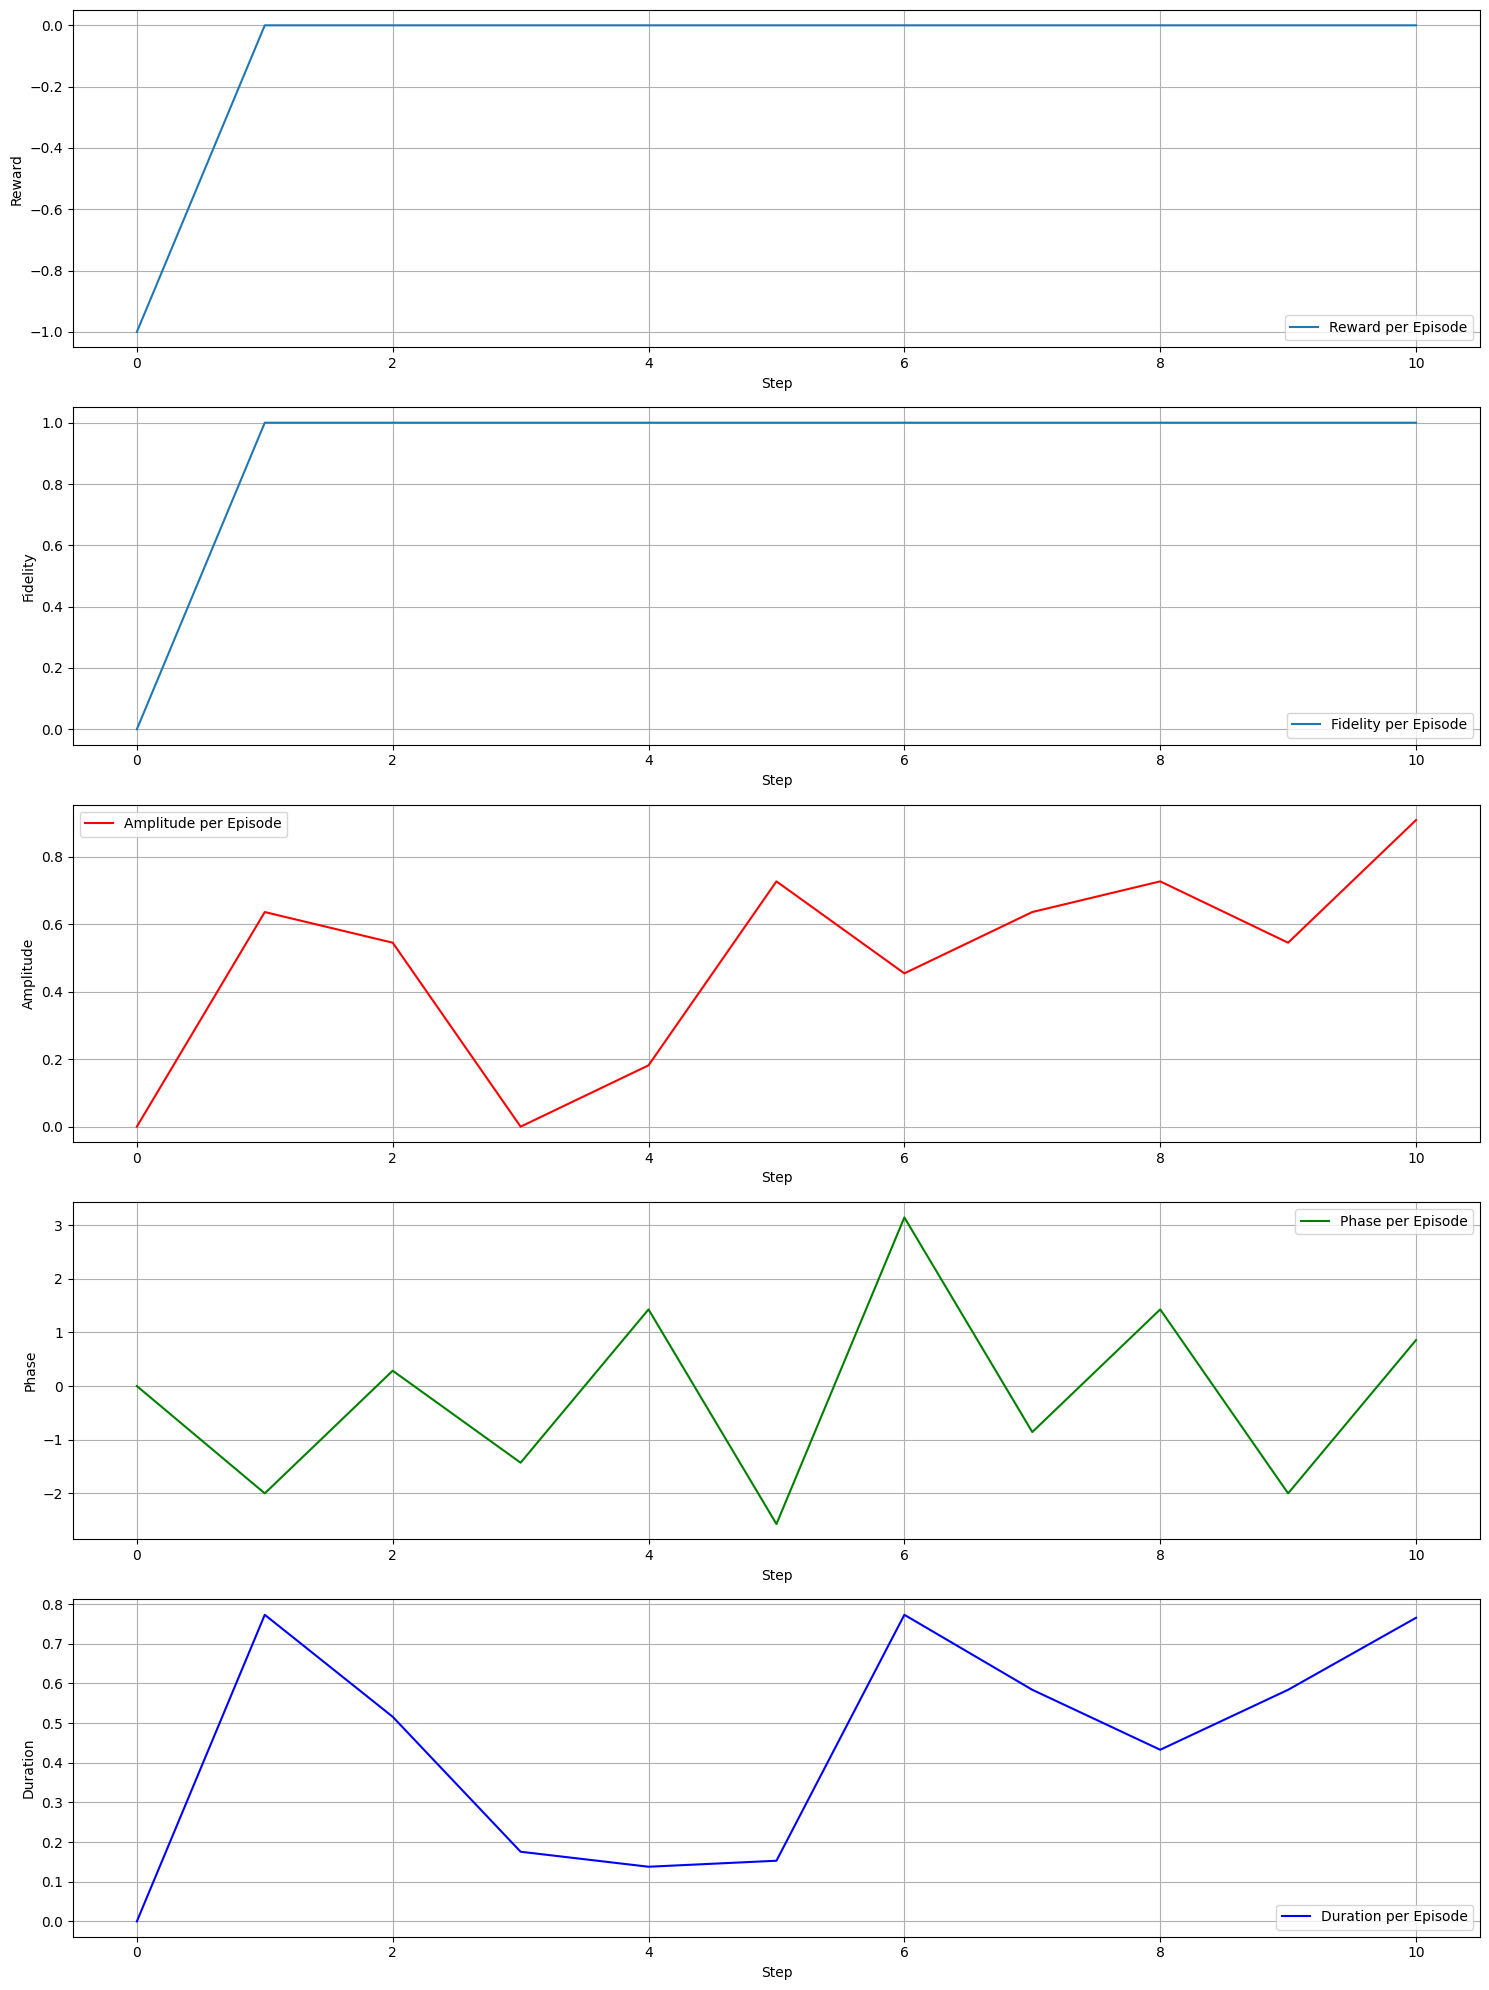

In [21]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

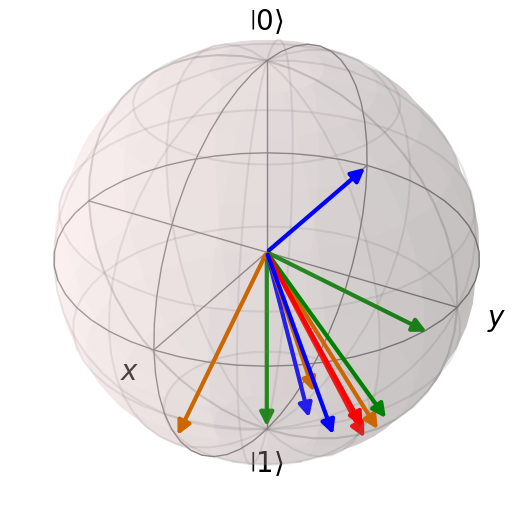

In [22]:
plot_bloch_sphere_trajectory(env.state_episode)

T-Gate

In [23]:
env = QuantumGateEnv(gate="T")
agent = REINFORCEAgent(env.state_size, env.action_size)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.21256, Fidelity: 0.78744
Episode: 2000/200000,  Reward: -0.19339, Fidelity: 0.80661
Episode: 4000/200000,  Reward: -0.69744, Fidelity: 0.30256
Episode: 6000/200000,  Reward: -0.76639, Fidelity: 0.23361
Episode: 8000/200000,  Reward: -0.30996, Fidelity: 0.69004
Episode: 10000/200000,  Reward: -0.00901, Fidelity: 0.99099
Episode: 12000/200000,  Reward: -0.67537, Fidelity: 0.32463
Episode: 14000/200000,  Reward: -0.23447, Fidelity: 0.76553
Episode: 16000/200000,  Reward: -0.58583, Fidelity: 0.41417
Episode: 18000/200000,  Reward: -0.18977, Fidelity: 0.81023
Episode: 20000/200000,  Reward: -0.65512, Fidelity: 0.34488
Episode: 22000/200000,  Reward: -0.09680, Fidelity: 0.90320
Episode: 24000/200000,  Reward: -0.98015, Fidelity: 0.01985
Episode: 26000/200000,  Reward: -0.91467, Fidelity: 0.08533
Episode: 28000/200000,  Reward: -0.93635, Fidelity: 0.06365
Episode: 30000/200000,  Reward: -0.06987, Fidelity: 0.93013
Episode: 32000/200000,  Reward: -0.20686, Fideli

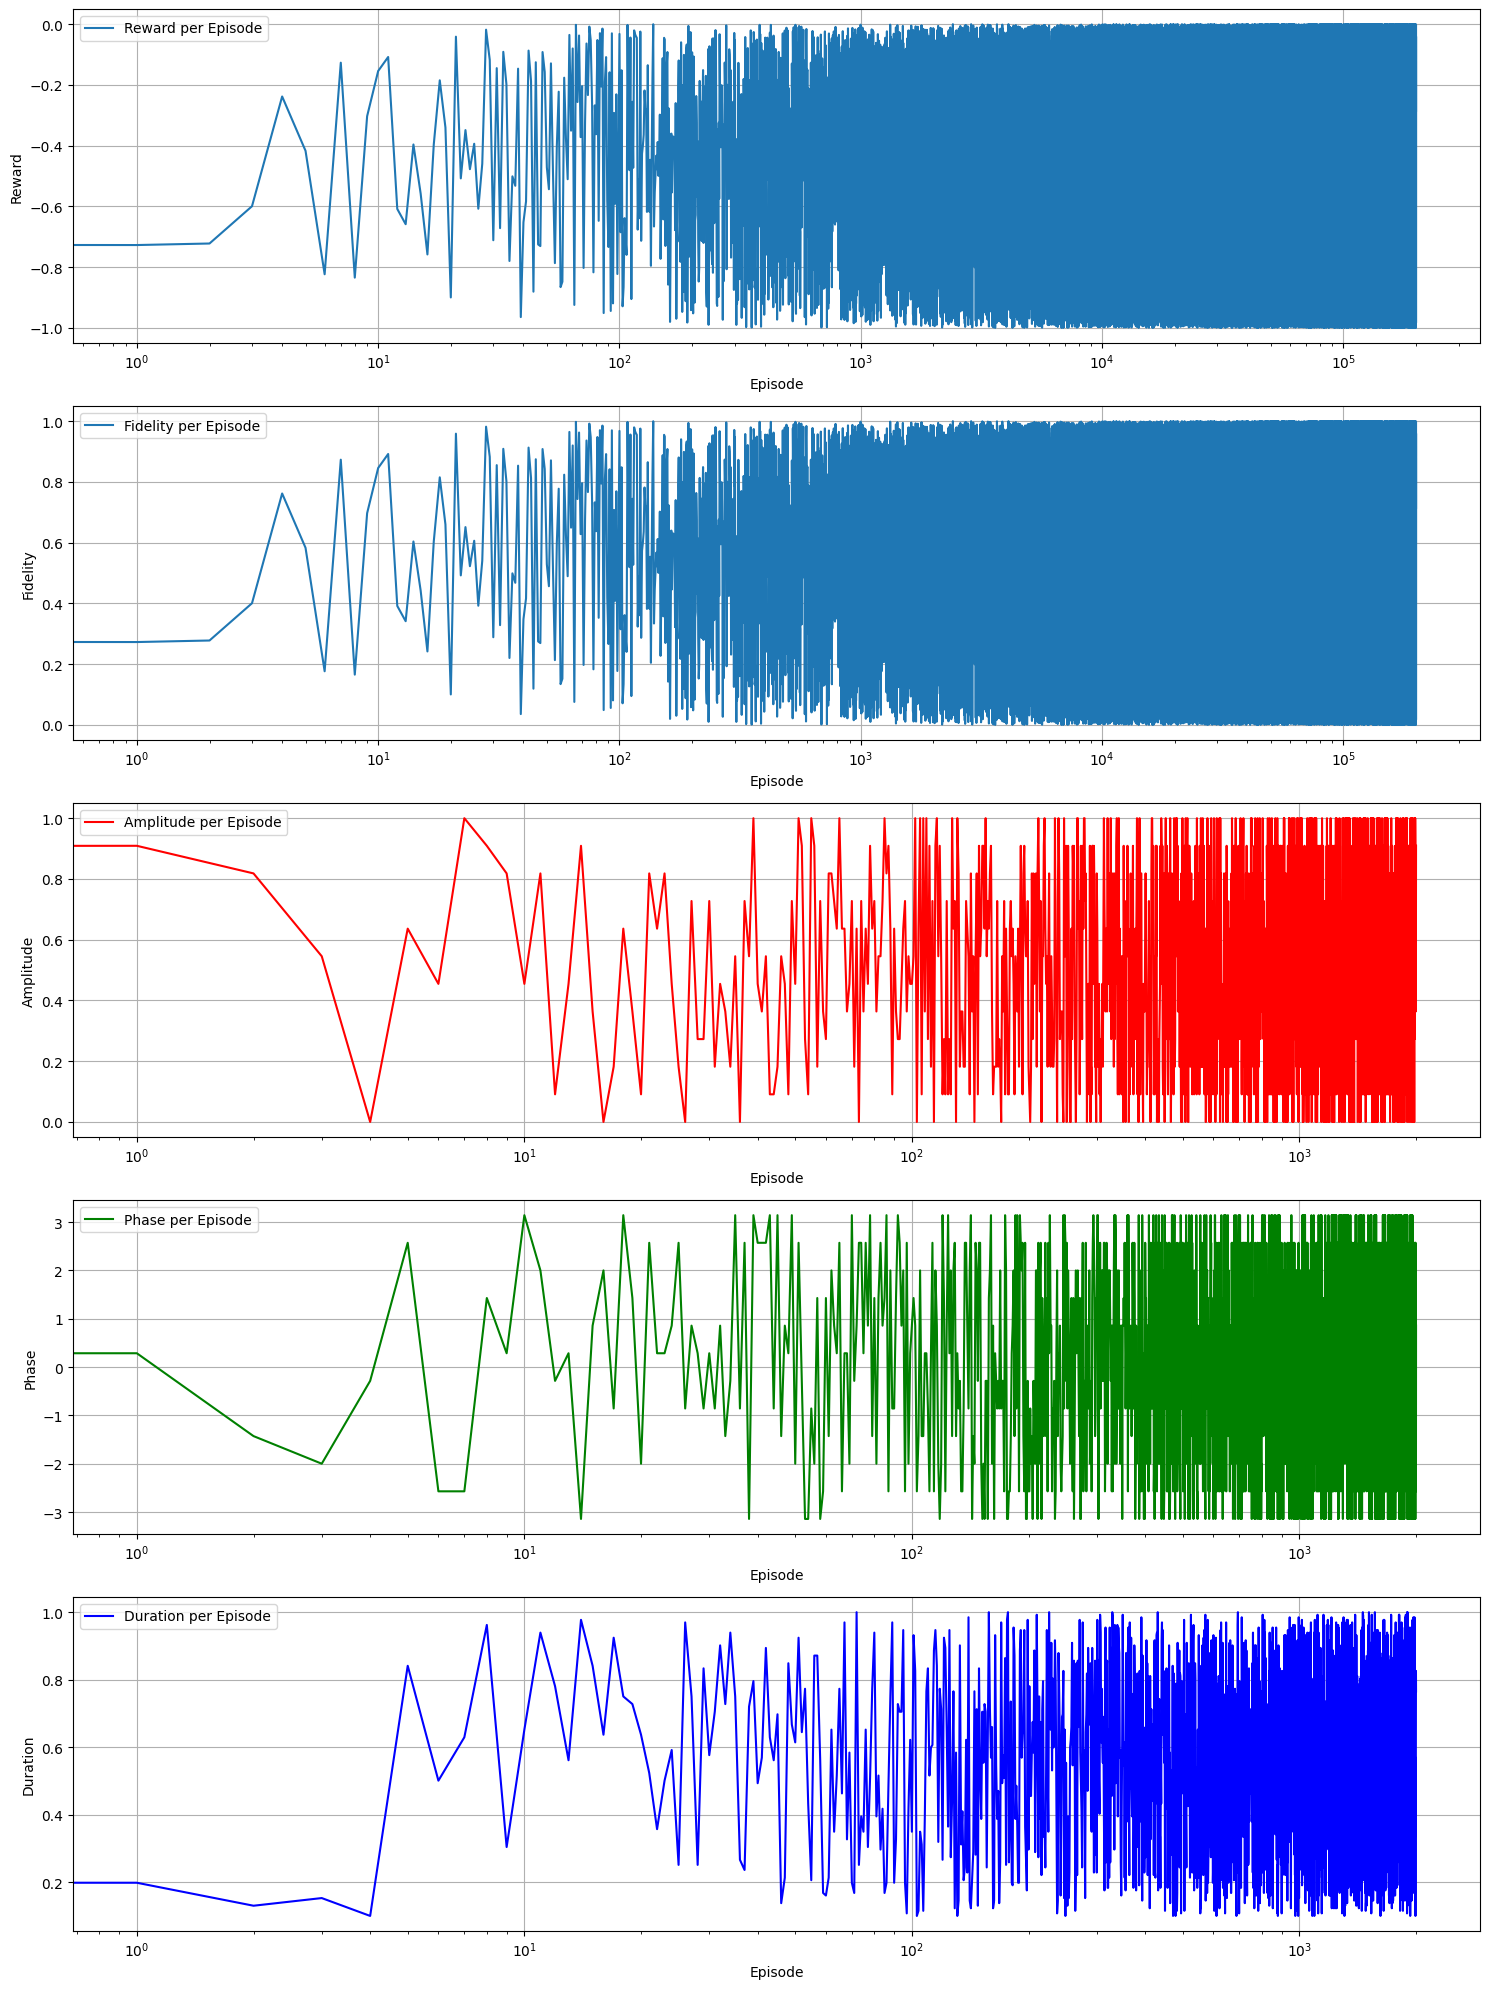

In [24]:
plot_results(
    reward_history,
    fidelity_history,
    amplitude_history,
    phase_history,
    duration_history,
    False,
)

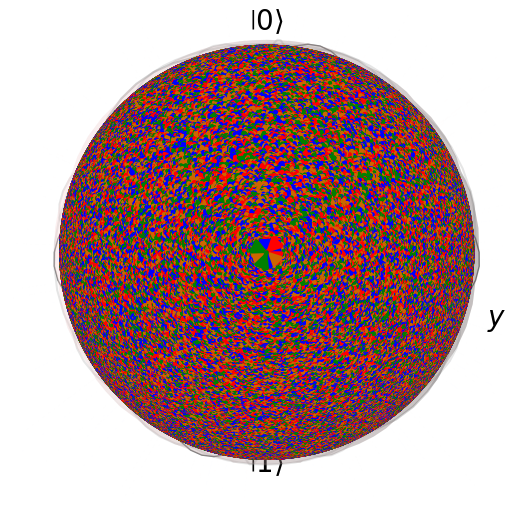

In [25]:
plot_bloch_sphere_trajectory(state_history)

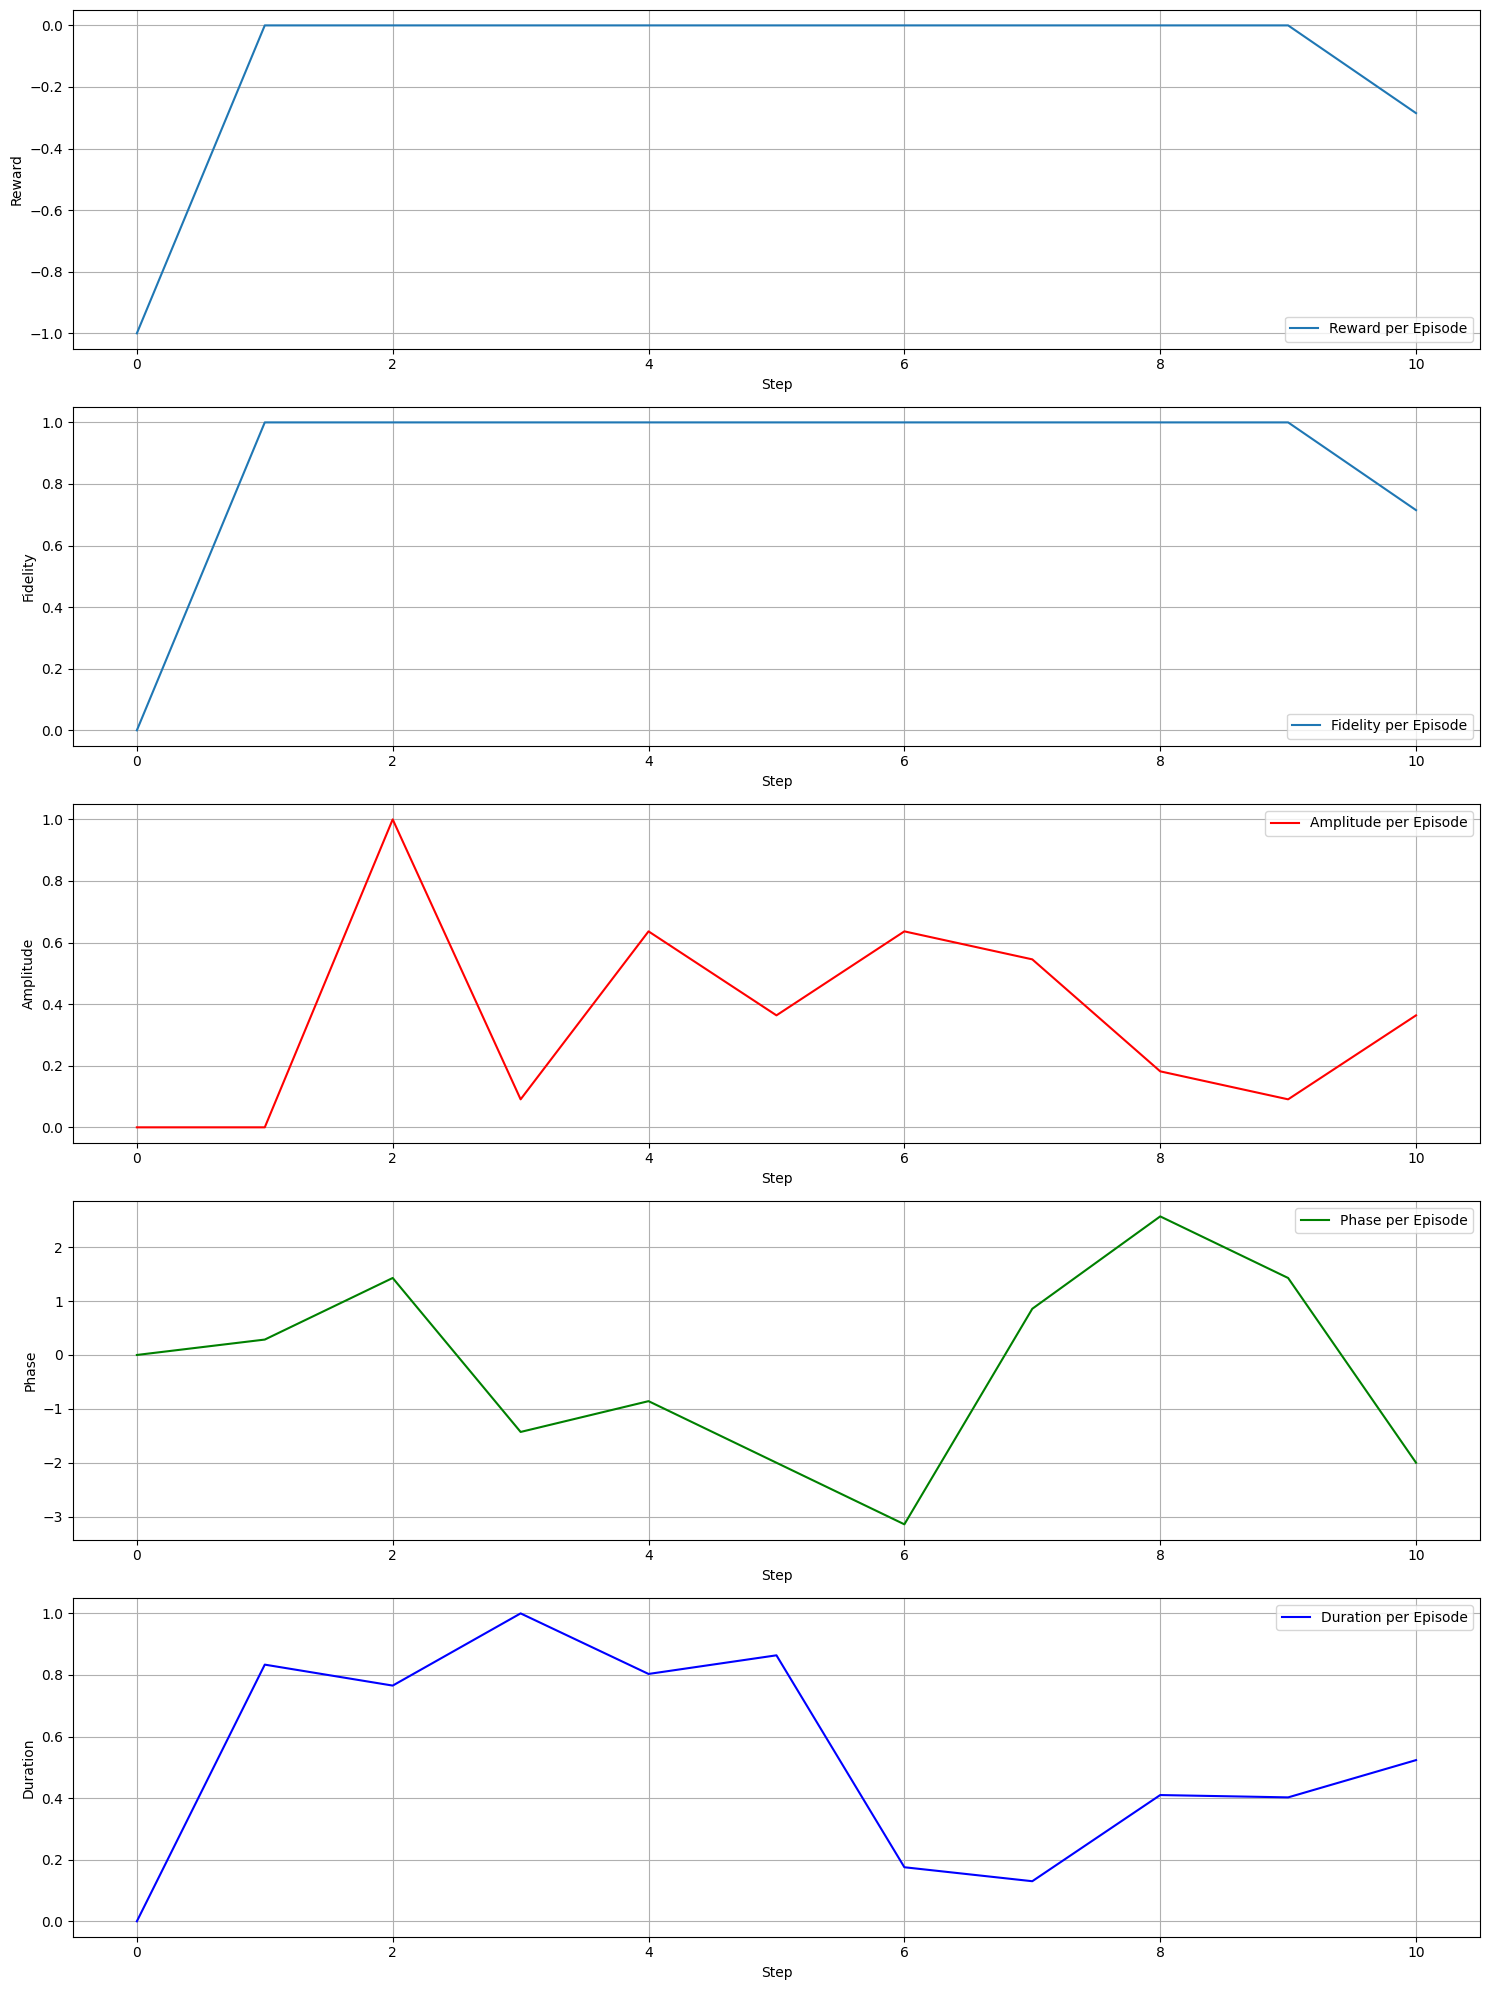

In [26]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

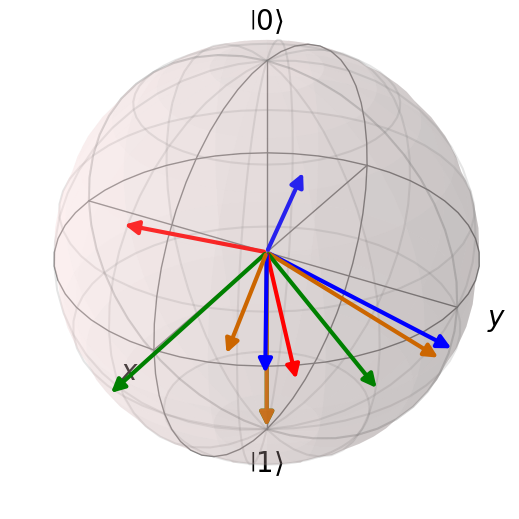

In [27]:
plot_bloch_sphere_trajectory(env.state_episode)

CNOT-Gate

In [28]:
env = QuantumGateEnv(gate="CNOT")
agent = REINFORCEAgent(env.state_size, env.action_size)

(
    reward_history,
    fidelity_history,
    state_history,
    amplitudes_history,
    phases_history,
    durations_history,
) = train_agent(agent, env, EPISODES, TARGET_UPDATE, FIDELITY_THRESHOLD, PATIENCE)

Episode: 0/200000,  Reward: -0.31862, Fidelity: 0.68138
Episode: 2000/200000,  Reward: -0.85629, Fidelity: 0.14371
Episode: 4000/200000,  Reward: -0.74513, Fidelity: 0.25487
Episode: 6000/200000,  Reward: -0.99090, Fidelity: 0.00910
Episode: 8000/200000,  Reward: -0.72074, Fidelity: 0.27926
Episode: 10000/200000,  Reward: -0.87281, Fidelity: 0.12719
Episode: 12000/200000,  Reward: -0.75134, Fidelity: 0.24866
Episode: 14000/200000,  Reward: -0.91537, Fidelity: 0.08463
Episode: 16000/200000,  Reward: -0.60915, Fidelity: 0.39085
Episode: 18000/200000,  Reward: -0.64646, Fidelity: 0.35354
Episode: 20000/200000,  Reward: -0.74740, Fidelity: 0.25260
Episode: 22000/200000,  Reward: -0.89675, Fidelity: 0.10325
Episode: 24000/200000,  Reward: -0.54180, Fidelity: 0.45820
Episode: 26000/200000,  Reward: -0.91555, Fidelity: 0.08445
Episode: 28000/200000,  Reward: -0.82262, Fidelity: 0.17738
Episode: 30000/200000,  Reward: -0.71630, Fidelity: 0.28370
Episode: 32000/200000,  Reward: -0.46952, Fideli

In [29]:
def plot_q_sphere(states):
    """
    Plot the QSphere for a list of quantum states.

    Parameters:
    states: list of quantum states in the form of complex-valued numpy arrays
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Draw the QSphere (Bloch sphere)
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color="r", alpha=0.1)

    # Plot the initial state with a distinct color
    initial_state = states[0]
    alpha_init = initial_state[0]
    beta_init = initial_state[1]

    theta_init = 2 * np.arccos(np.abs(alpha_init))  # Polar angle
    phi_init = np.angle(beta_init) - np.angle(alpha_init)  # Azimuthal angle

    x_init = np.sin(theta_init) * np.cos(phi_init)
    y_init = np.sin(theta_init) * np.sin(phi_init)
    z_init = np.cos(theta_init)

    ax.plot([0, x_init], [0, y_init], [0, z_init], color="black", linestyle="--")
    ax.scatter(x_init, y_init, z_init, color="black", s=100)

    # Plot the other states
    for state in states[1:]:
        alpha = state[0]
        beta = state[1]

        # Calculate spherical coordinates
        theta = 2 * np.arccos(np.abs(alpha))  # Polar angle
        phi = np.angle(beta) - np.angle(alpha)  # Azimuthal angle

        # Cartesian coordinates
        x = np.sin(theta) * np.cos(phi)
        y = np.sin(theta) * np.sin(phi)
        z = np.cos(theta)

        # Color based on phase
        color = cm.hsv((phi + np.pi) / (2 * np.pi))

        ax.plot([0, x], [0, y], [0, z], color=color)
        ax.scatter(x, y, z, color=color, s=100)

    # Set axis limits
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

    # Set labels
    ax.set_xlabel("Re(α)")
    ax.set_ylabel("Im(α)")
    ax.set_zlabel("Re(β)")
    plt.show()

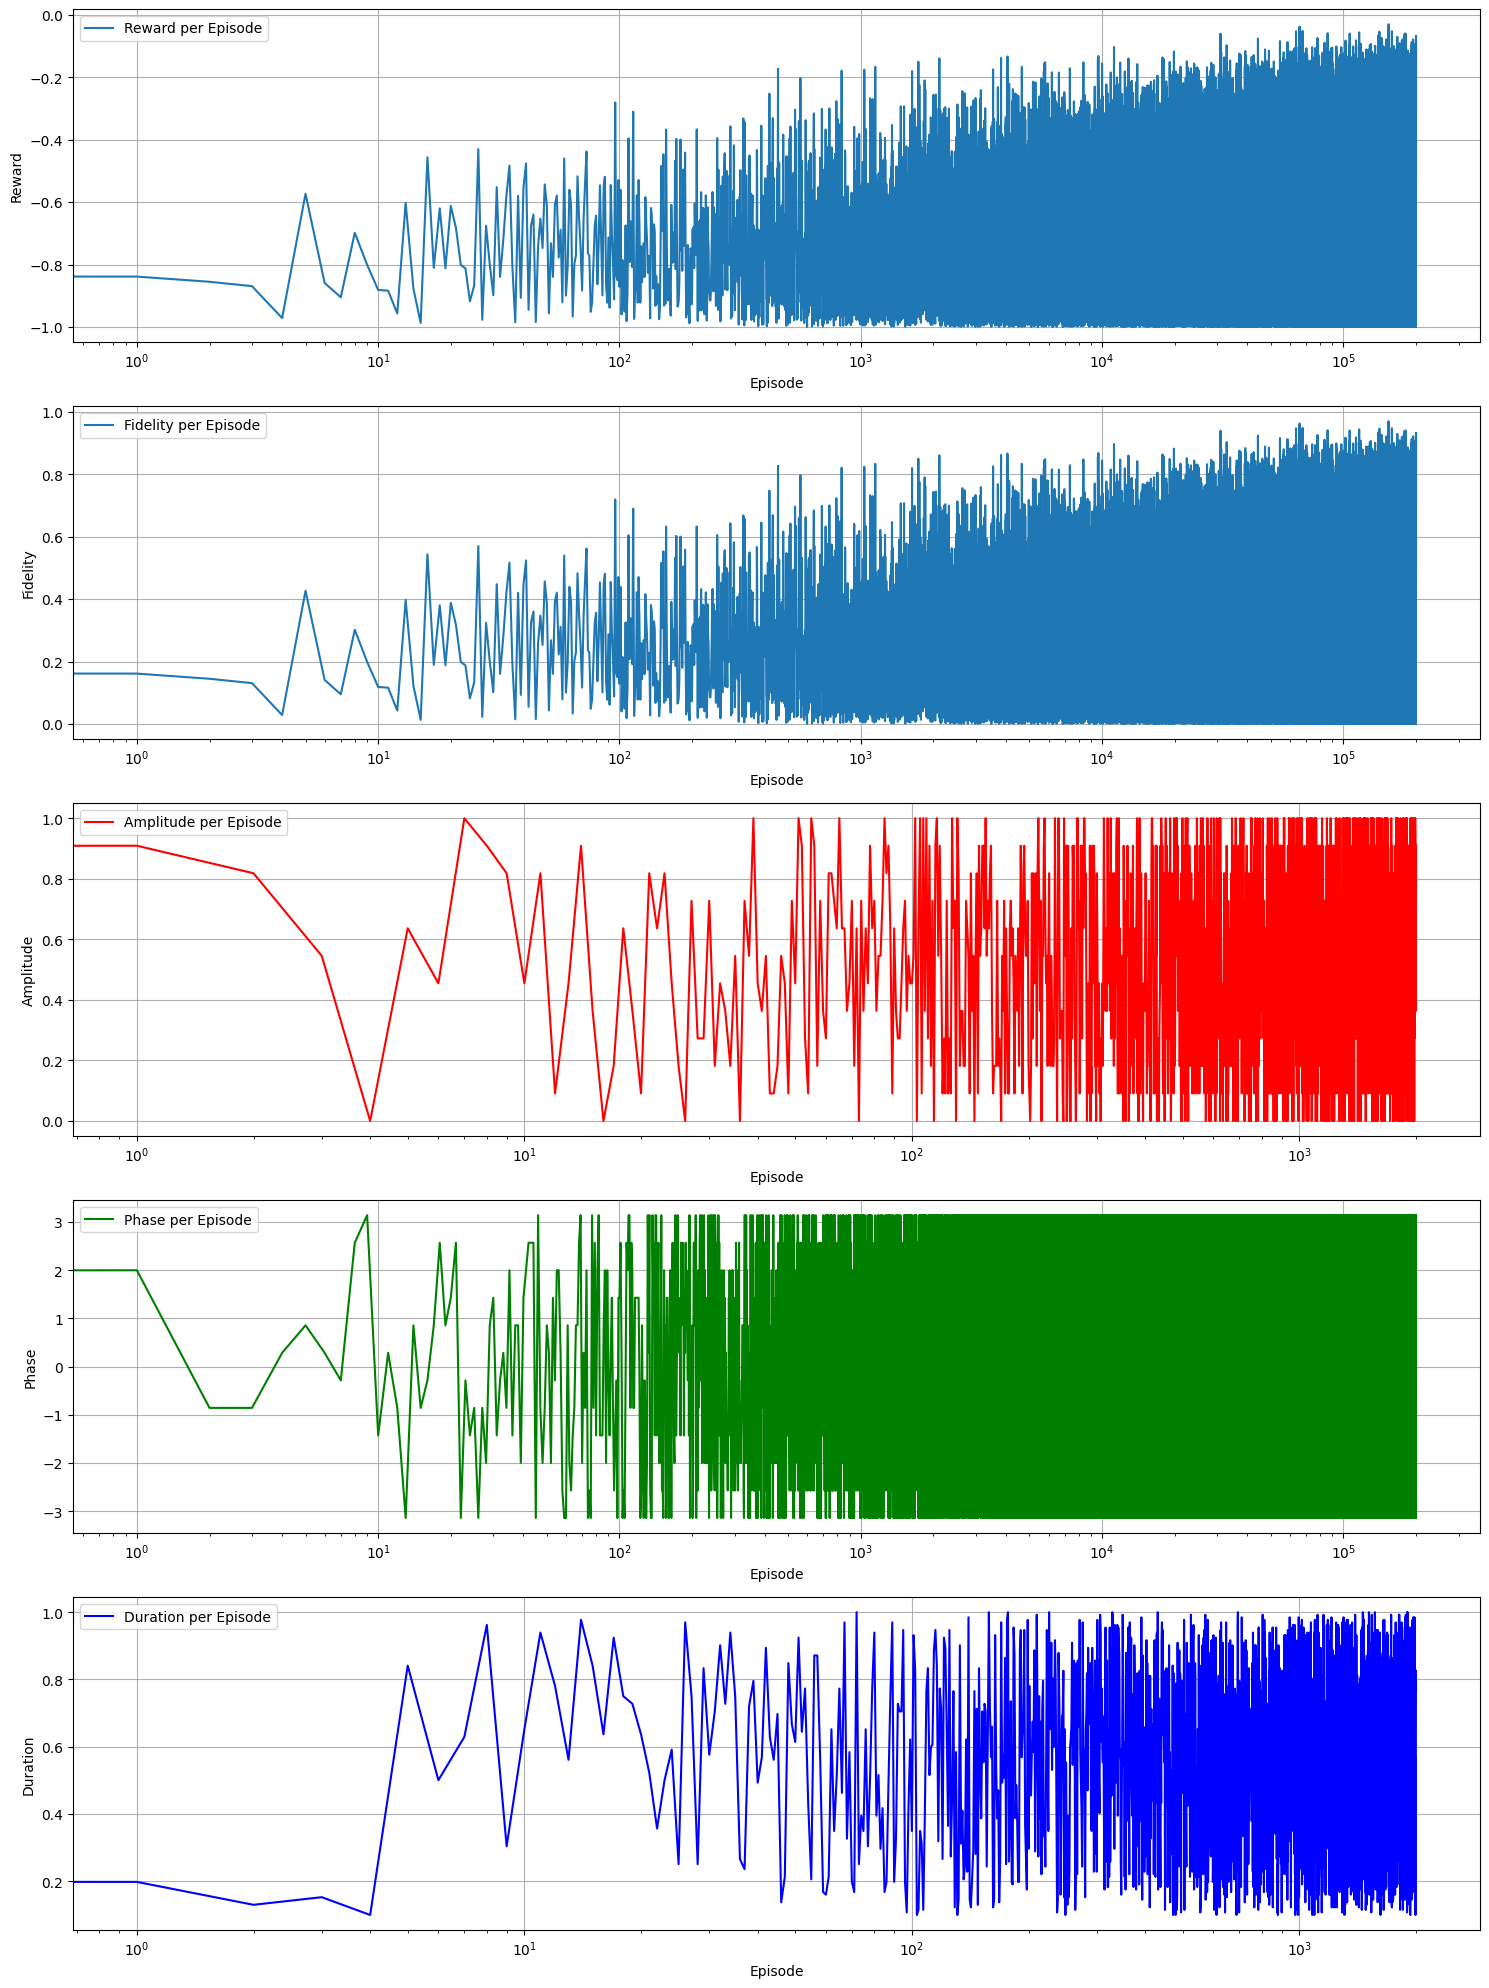

In [30]:
plot_results(
    reward_history,
    fidelity_history,
    amplitude_history,
    phases_history,
    duration_history,
    False,
)

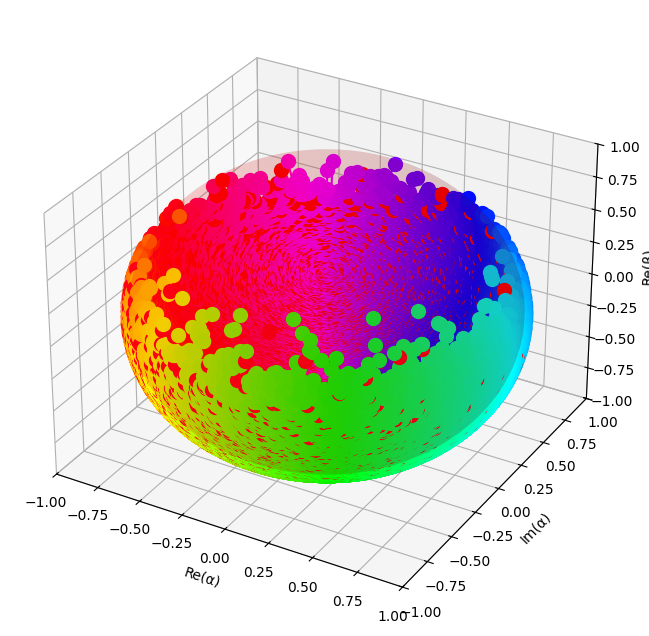

In [31]:
plot_q_sphere(state_history)

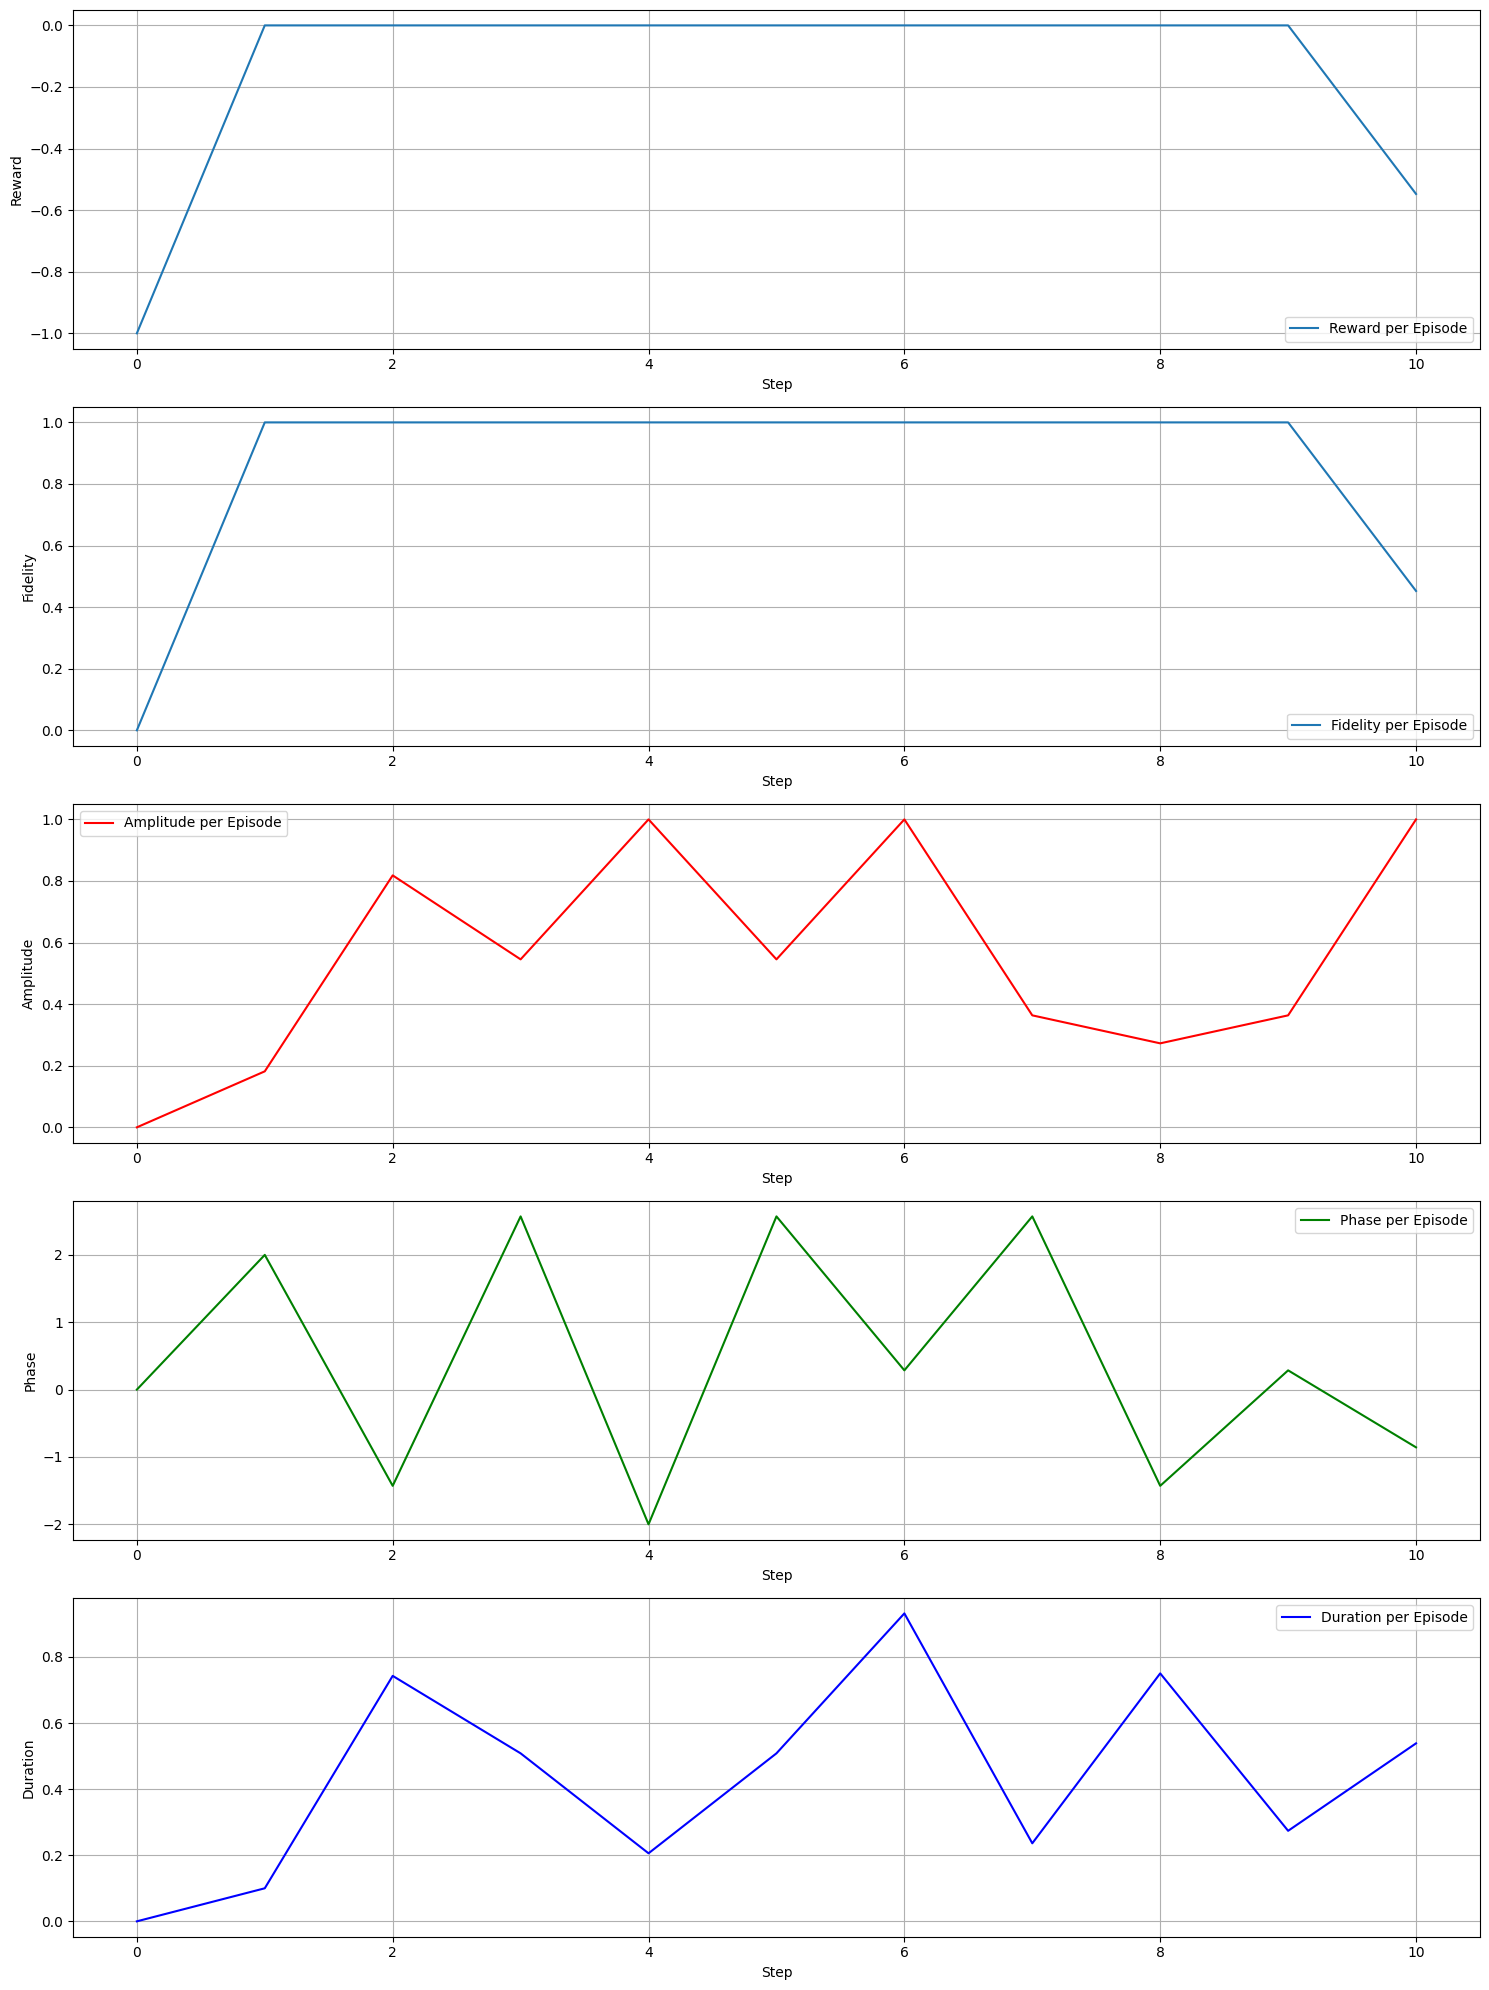

In [32]:
plot_results(
    env.reward_episode,
    env.fidelity_episode,
    env.amplitude_episode,
    env.phase_episode,
    env.duration_episode,
    True,
)

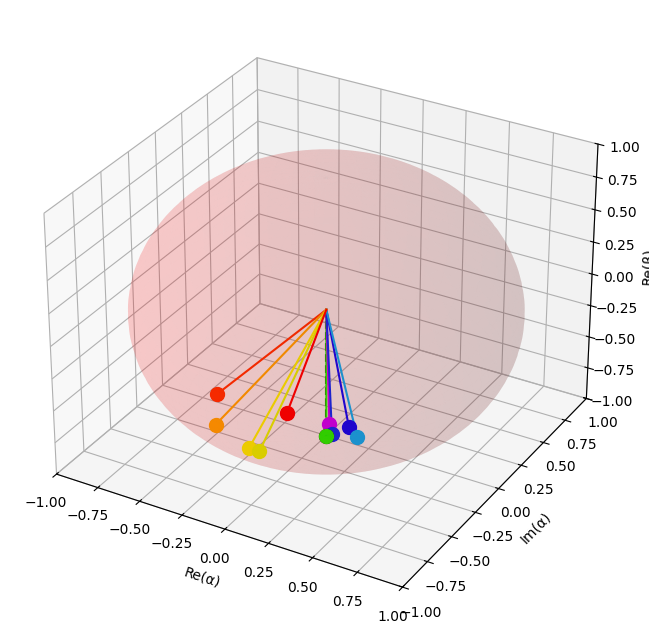

In [33]:
plot_q_sphere(env.state_episode)